# Analysis of High-Frequency Crypto Trade Data (BTC/USDT)

## Project Overview

This project demonstrates an efficient pipeline for processing a large, raw tick-level trade dataset to uncover basic market microstructure insights.

The key tasks include:
1.  **Data Aggregation:** Efficiently loading millions of raw trades and aggregating them into conventional 1-minute OHLCV bars using a memory-friendly, chunk-based approach.
2.  **Volatility-Volume Analysis:** Investigating the correlation between trading volume and price volatility on a 1-minute timeframe.
3.  **Market Activity Segmentation:** Segmenting the data into high- and low-activity periods based on volume and comparing their volatility characteristics.

## 1. Imports

In [24]:
import pandas as pd
import numpy as np
import pyarrow
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Loading and Aggregation
In this section, a large raw trade data file (over 1 GB, containing millions of trades for May 2025) is loaded into a Pandas DataFrame. Due to the file size, data is read in chunks to manage memory usage efficiently. Column names are assigned according to the Binance API documentation, and data types are optimized for performance.

In [25]:
# --- Configuration ---
RAW_DATA_DIR = 'raw_data'
INPUT_FILENAME = 'BTCUSDT-trades-2025-05.csv'
FILE_PATH = os.path.join(RAW_DATA_DIR, INPUT_FILENAME)

# Column names are based on the official Binance documentation for spot trade data.
COLUMN_NAMES = [
    'trade_id', 'price', 'quantity', 'quote_quantity', 'timestamp', 
    'is_buyer_maker', 'is_best_match'
]

# Data types for efficient memory usage during loading.
DTYPE_MAPPING = {
    'trade_id': 'uint64',
    'price': 'float32',
    'quantity': 'float32',
    'quote_quantity': 'float32',
    'is_buyer_maker': 'bool',
    'is_best_match': 'bool'
}

To handle the large file size, we process the data in chunks. Each chunk is read, its data types are converted, and it's immediately resampled into 1-minute intervals. This "on-the-fly" aggregation is highly memory-efficient, as the full high-frequency dataset is never loaded into memory at once.

In [26]:
chunk_size = 5_000_000

# Create an iterator to read the CSV in chunks, applying efficient data types on read.
chunk_iterator = pd.read_csv(
    FILE_PATH, 
    header=None,
    names=COLUMN_NAMES,
    dtype=DTYPE_MAPPING,
    chunksize=chunk_size
)

list_of_resampled_chunks = []
print("Processing file in chunks and resampling on-the-fly...")

for i, chunk in enumerate(chunk_iterator):
    print(f"Processing chunk {i+1}...")
    
    # Convert Unix timestamp (in microseconds) to datetime objects
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='us')
    chunk.set_index('timestamp', inplace=True)
    
    # Resample this individual chunk into 1-minute bars
    aggregation_logic = {
        'price': 'ohlc',
        'quantity': 'sum',
        'quote_quantity': 'sum',
        'is_buyer_maker': 'mean'
    }
    resampled_chunk = chunk.resample('1Min').agg(aggregation_logic)
    
    list_of_resampled_chunks.append(resampled_chunk)

print("All chunks have been processed and resampled.")

print("Concatenating resampled chunks...")
minute_bars_df = pd.concat(list_of_resampled_chunks)

Processing file in chunks and resampling on-the-fly...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
All chunks have been processed and resampled.
Concatenating resampled chunks...


In [27]:
# Perform a final groupby aggregation to correctly combine data for minutes that spanned across chunks.
# The logic uses the multi-index column names produced by the initial resample.
print("Performing final aggregation of minute-level data...")
final_aggregation_logic = {
    ('price', 'open'): 'first',
    ('price', 'high'): 'max',
    ('price', 'low'): 'min',
    ('price', 'close'): 'last',
    ('quantity', 'quantity'): 'sum',
    ('quote_quantity', 'quote_quantity'): 'sum',
    ('is_buyer_maker', 'is_buyer_maker'): 'mean'
}
minute_bars_df = minute_bars_df.groupby(minute_bars_df.index).agg(final_aggregation_logic)


# Now, we rename the final columns. The keys in the dictionary must match the output of the groupby.
minute_bars_df.columns = [
    'Open', 'High', 'Low', 'Close', 
    'Volume_BTC', 'Volume_USDT', 'Buyer_Maker_Ratio'
]

print("Final aggregation and renaming complete.")
print("\n--- Final Aggregated DataFrame Head ---")
print(minute_bars_df.head())

Performing final aggregation of minute-level data...
Final aggregation and renaming complete.

--- Final Aggregated DataFrame Head ---
                             Open          High           Low         Close  \
timestamp                                                                     
2025-05-01 00:00:00  94172.000000  94177.960938  94130.429688  94147.296875   
2025-05-01 00:01:00  94147.312500  94190.468750  94147.296875  94187.023438   
2025-05-01 00:02:00  94187.007812  94198.773438  94187.007812  94198.750000   
2025-05-01 00:03:00  94198.750000  94198.757812  94169.453125  94169.453125   
2025-05-01 00:04:00  94169.460938  94238.101562  94156.726562  94238.093750   

                     Volume_BTC    Volume_USDT  Buyer_Maker_Ratio  
timestamp                                                          
2025-05-01 00:00:00     6.47436  609602.125000           0.637500  
2025-05-01 00:01:00     3.97781  374634.250000           0.155386  
2025-05-01 00:02:00     2.24103  211095

In [28]:
# 2.3: Save the aggregated data to a Parquet file for faster access in future analyses 
PROCESSED_DATA_DIR = 'processed_data'
OUTPUT_FILENAME_PARQUET = 'BTCUSDT-trades-2025-05-1Min.parquet'
OUTPUT_PATH_PARQUET = os.path.join(PROCESSED_DATA_DIR, OUTPUT_FILENAME_PARQUET)

try:
    minute_bars_df.to_parquet(OUTPUT_PATH_PARQUET)
    print(f"\nAggregated data successfully saved to Parquet file: {OUTPUT_PATH_PARQUET}")
except ImportError:
    print("\n'pyarrow' library not found. Cannot save to Parquet. Please install it using: pip install pyarrow")
    # Fallback to CSV if needed
    OUTPUT_FILENAME_CSV = 'BTCUSDT-trades-2025-05-1Min.csv'
    OUTPUT_PATH_CSV = os.path.join(PROCESSED_DATA_DIR, OUTPUT_FILENAME_CSV)
    minute_bars_df.to_csv(OUTPUT_PATH_CSV)
    print(f"Aggregated data saved to CSV file instead: {OUTPUT_PATH_CSV}")
    
# Display final DataFrame head and info
# print("\n--- Final Aggregated DataFrame Info ---")
# minute_bars_df.info()
# print("\n--- Final Aggregated DataFrame Head ---")
# minute_bars_df.head()


Aggregated data successfully saved to Parquet file: processed_data\BTCUSDT-trades-2025-05-1Min.parquet


The raw tick data is resampled into 1-minute OHLCV (Open, High, Low, Close, Volume) bars. This aggregation allows for analysis on a more conventional timeframe and reduces noise. The process involves grouping all ticks within each minute and applying specific aggregation functions (`ohlc` for price, `sum` for volume). The resulting clean, aggregated data is saved to a Parquet file for faster access in future analyses.

## 3. Exploratory Data Analysis (EDA)

Now, using the clean, 1-minute aggregated data, we can perform some exploratory analysis.

In [29]:
# Load the aggregated data for analysis
# This ensures the EDA section is independently runnable if the kernel is restarted.
df = pd.read_parquet(OUTPUT_PATH_PARQUET)

# Create a 'Volatility' column for analysis
df['Volatility'] = df['High'] - df['Low']

print("Aggregated data loaded for analysis.")
df.head()

Aggregated data loaded for analysis.


,Open,High,Low,Close,Volume_BTC,Volume_USDT,Buyer_Maker_Ratio,Volatility
timestamp,,,,,,,,
2025-05-01 00:00:00,94172.000000,94177.960938,94130.429688,94147.296875,6.47436,609602.125000,0.637500,47.531250
2025-05-01 00:01:00,94147.312500,94190.468750,94147.296875,94187.023438,3.97781,374634.250000,0.155386,43.171875
2025-05-01 00:02:00,94187.007812,94198.773438,94187.007812,94198.750000,2.24103,211095.078125,0.303653,11.765625
2025-05-01 00:03:00,94198.750000,94198.757812,94169.453125,94169.453125,3.31848,312557.906250,0.953668,29.304688
2025-05-01 00:04:00,94169.460938,94238.101562,94156.726562,94238.093750,7.51438,707738.625000,0.176427,81.375000


### 3.1. Relationship between Volume and Volatility

A common market hypothesis is that high trading volume is correlated with high price volatility. To investigate this, we first need a measure of volatility for each 1-minute bar.

For this analysis, we will use a simple and effective proxy for intrabar volatility: the range between the High and Low prices (`High - Low`). While a more statistically robust measure would be the standard deviation of all tick prices within each minute, this range-based metric is computationally efficient and excellent for capturing the magnitude of price movement within the bar.

Correlation between BTC Volume and Price Volatility (1-Min): 0.6577


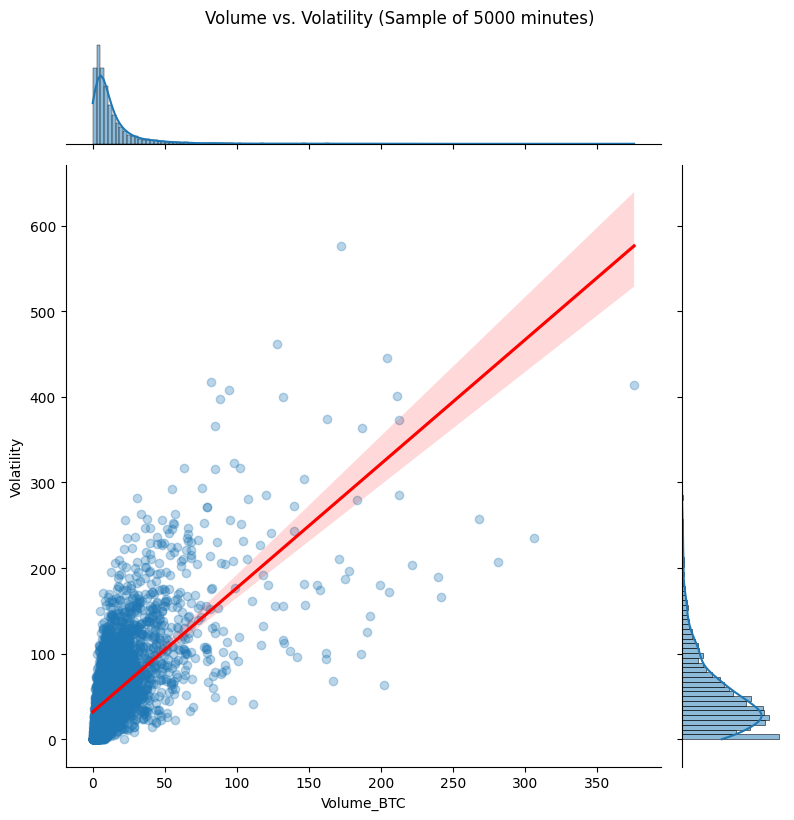

In [30]:
# Calculate the Pearson correlation coefficient
correlation = df['Volume_BTC'].corr(df['Volatility'])
print(f"Correlation between BTC Volume and Price Volatility (1-Min): {correlation:.4f}")

# A sample is used for the scatter plot to keep it readable.
g = sns.jointplot(
    x='Volume_BTC', 
    y='Volatility', 
    data=df.sample(n=5000, random_state=1), 
    kind='reg',
    height=8,
    joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}}
)
g.fig.suptitle('Volume vs. Volatility (Sample of 5000 minutes)', y=1.02)
plt.show()

**Observation:** The analysis confirms a positive correlation (0.6577) between trading volume and price volatility. As shown in the plot, minutes with higher trading volumes tend to be associated with wider price ranges.

### 3.2. Analysis of High vs. Low Activity Periods

Next, we segment the data into groups based on trading volume to see if high-activity periods exhibit different characteristics than low-activity periods. "High Activity" is defined as the top 25% of minutes by volume.

Average volatility comparison:
Activity_Group
High    101.127533
Low      37.274155
Name: Volatility, dtype: float32


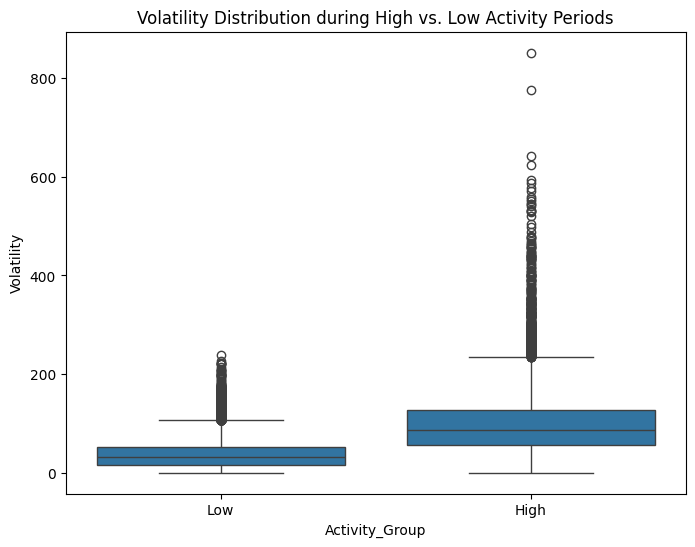

In [31]:
high_activity_threshold = df['Volume_BTC'].quantile(0.75)
df['Activity_Group'] = np.where(df['Volume_BTC'] > high_activity_threshold, 'High', 'Low')

# Compare average volatility
print("Average volatility comparison:")
print(df.groupby('Activity_Group')['Volatility'].mean())

# Visualize the distribution of volatility for each group
plt.figure(figsize=(8, 6))
sns.boxplot(x='Activity_Group', y='Volatility', data=df, order=['Low', 'High'])
plt.title('Volatility Distribution during High vs. Low Activity Periods')
plt.show()

**Observation:** The boxplot clearly illustrates that both the median and overall distribution of volatility are significantly greater during high-activity periods. This reinforces the finding that increased market participation is strongly linked to larger price movements.

## 4. Conclusion

This project successfully demonstrated an efficient pipeline for processing large-scale tick data into structured, analyzable 1-minute bars using Python and Pandas. The exploratory analysis confirmed fundamental market microstructure behaviors, such as the positive correlation between trading volume and price volatility. This process of data aggregation and feature engineering is a foundational step for quantitative research and the development of trading strategies.